In [1]:
import sys
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
folder_path = "/home/yaga/Documents/GitHub/mfpml"
sys.path.insert(0, folder_path)

# import local functions
from mfpml.design_of_experiment.sf_samplers import LatinHyperCube
from mfpml.problems.sf_functions import Branin
from mfpml.design_of_experiment.plot_figures import plot_sf_sampling
from mfpml.models.gaussian_processes import Kriging
from sklearn.metrics import r2_score, mean_squared_error, max_error

In [2]:
# define the test function 
function = Branin() 
num_trial = 10 
record_results_gpy = np.zeros((num_trial, 3)) 
record_results_scipy = np.zeros((num_trial, 3)) 
record_results_own = np.zeros((num_trial, 3)) 
# get the number of variables
num_dim = function.num_dim
# user-defined parameters
num_sample = 30
# define the design space
design_space = function.design_space

## gpytorch 

In [3]:
for jj in range(num_trial):
    # sampling
    sampler = LatinHyperCube(design_space=design_space, seed=None)
    sample_x = sampler.get_samples(num_samples=num_sample)
    sample_y = function.f(sample_x)
    train_x = torch.from_numpy(sample_x)
    train_y = torch.from_numpy(sample_y).flatten()

    # gpr model
    gprmodel = Kriging()
    gprmodel.train(
        train_x=train_x.clone(),
        train_y=train_y.clone(),
        design_space=function.design_space,
        normlize=True,
        training_iteration=500,
        learning_rate=0.02,
        print_info=False,
    )
    # prediction
    num_test = 1000
    test_x = sampler.get_samples(num_samples=num_test)
    test_y = function.f(test_x.copy()).flatten()
    test_x = torch.from_numpy(test_x)
    # pred_mean = gprmodel.predict(test_x=test_x.clone()).mean.numpy()
    pred = gprmodel.predict(test_x=test_x.clone())
    pred_mean = pred.mean.numpy()

    # calculate different metrics to record the accuracy of the prediction
    mse = mean_squared_error(pred_mean, test_y)
    r2 = r2_score(pred_mean, test_y)
    mae = max_error(pred_mean, test_y)

    # record the results
    record_results_gpy[jj, :] = np.array([mse, r2, mae])


/home/yaga/miniconda3/envs/MLenv3/lib/python3.10/site-packages/gpytorch/likelihoods/noise_models.py:144: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/yaga/miniconda3/envs/MLenv3/lib/python3.10/site-packages/gpytorch/likelihoods/noise_models.py:144: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/yaga/miniconda3/envs/MLenv3/lib/python3.10/site-packages/gpytorch/likelihoods/noise_models.py:144: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/yaga/miniconda3/envs/MLenv3/lib/python3.10/site-packages/gpytorch/likelihoods/noise_models.py:144: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilit

In [4]:
print(record_results_gpy)

[[3.42905407e+02 8.21420613e-01 1.96405365e+02]
 [2.64391465e+02 8.70484077e-01 1.59372303e+02]
 [2.15580220e+02 8.97836522e-01 7.77343570e+01]
 [2.62143297e+02 8.83700335e-01 1.50895372e+02]
 [7.67614791e+02 6.70496391e-01 1.33397481e+02]
 [1.12228017e+02 9.56708284e-01 4.76396375e+01]
 [2.95010736e+02 8.59950486e-01 1.75613286e+02]
 [1.67442602e+02 9.16842262e-01 1.03787305e+02]
 [4.10134460e+02 8.00300953e-01 2.04994564e+02]
 [1.34136976e+02 9.38716797e-01 9.68484497e+01]]


## scipy_gpr model 

In [5]:
from pyro import sample
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
for jj in range(num_trial):
    # sampling
    sampler = LatinHyperCube(design_space=design_space, seed=None)
    sample_x = sampler.get_samples(num_samples=num_sample)
    sample_y = function.f(sample_x)
    rbf = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    # gpr model
    gprmodel = GaussianProcessRegressor(kernel=rbf, n_restarts_optimizer=20)
    gprmodel.fit(sample_x, sample_y)
    # prediction
    num_test = 1000
    test_x = sampler.get_samples(num_samples=num_test)
    test_y = function.f(test_x.copy())
    pred_mean, pred_std = gprmodel.predict(test_x, return_std=True)

    # calculate different metrics to record the accuracy of the prediction
    mse = mean_squared_error(pred_mean, test_y)
    r2 = r2_score(pred_mean, test_y)
    mae = max_error(pred_mean, test_y)

    # record the results
    record_results_scipy[jj, :] = np.array([mse, r2, mae])


In [6]:
print(record_results_scipy)

[[ 52.90035528   0.97974665  46.44986134]
 [172.98018141   0.94139221  57.57448276]
 [229.00644245   0.88374359 154.24130006]
 [174.7315469    0.93495527  80.93219015]
 [ 64.2515309    0.97213539  86.451709  ]
 [310.41684847   0.85854296 147.55275068]
 [149.81335969   0.93883002 133.28521694]
 [177.17252851   0.93179021  76.47001327]
 [137.07371856   0.93826161  90.41228296]
 [102.37851545   0.95726581 124.77512499]]


## own kriging model

In [7]:
from mfpml.models.kriging import Kriging

In [8]:
for jj in range(num_trial):
    # sampling
    sampler = LatinHyperCube(design_space=design_space, seed=None)
    sample_x = sampler.get_samples(num_samples=num_sample)
    sample_y = function.f(sample_x)
    # gpr model
    gprmodel  = Kriging(design_space=function._input_domain)
    gprmodel.train(sample_x, sample_y)
    # prediction
    num_test = 1000
    test_x = sampler.get_samples(num_samples=num_test)
    test_y = function.f(test_x.copy())
    pred_mean, pred_std = gprmodel.predict(test_x, return_std=True)

    # calculate different metrics to record the accuracy of the prediction
    mse = mean_squared_error(pred_mean, test_y)
    r2 = r2_score(pred_mean, test_y)
    mae = max_error(pred_mean, test_y)

    # record the results
    record_results_own[jj, :] = np.array([mse, r2, mae])

In [9]:
print(record_results_own)

[[ 0.67513808  0.9997463  13.04849663]
 [ 0.09385327  0.99996122  1.91036171]
 [ 0.20893981  0.9999197   1.96084821]
 [ 1.48476232  0.99947562 14.82985479]
 [ 0.79558212  0.99967352  8.00485882]
 [ 0.08784199  0.99996671  2.65850464]
 [ 0.13206283  0.99994532  3.62769554]
 [ 2.02395952  0.99922644 20.82480017]
 [ 0.93382433  0.99965017  9.01447581]
 [ 0.08110936  0.99996958  2.27775569]]


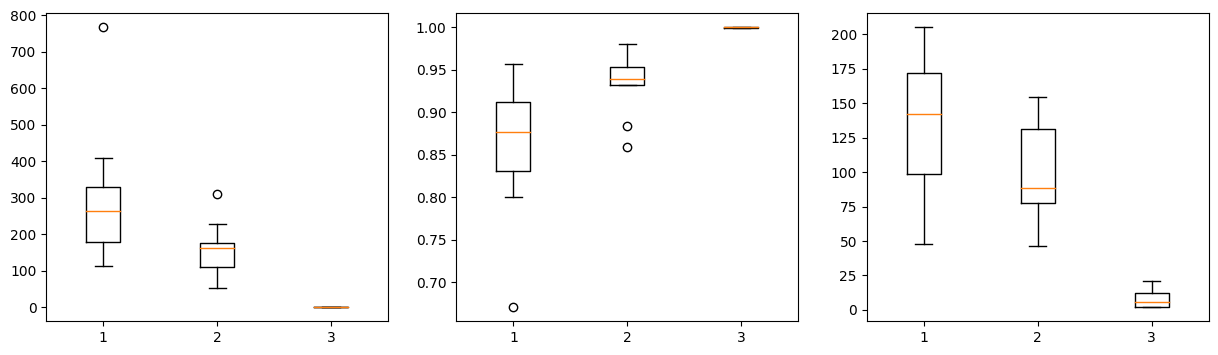

In [13]:
# plot all results 
import matplotlib.pyplot as plt 
mse = np.array([record_results_gpy[:,0],record_results_scipy[:,0],record_results_own[:,0] ]).T
r2 = np.array([record_results_gpy[:,1],record_results_scipy[:,1],record_results_own[:,1] ]).T
mae = np.array([record_results_gpy[:,2],record_results_scipy[:,2],record_results_own[:,2] ]).T
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].boxplot(mse)
ax[1].boxplot(r2)
ax[2].boxplot(mae)
plt.show()